In [40]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [41]:
df = pd.read_csv('incoming_packages.csv')

# Analysera datan

In [42]:
print(df)

           date  total_packages  cooled_packages  fire_packages   
0    2020-01-01            1745              370            488  \
1    2020-01-02            1847              308            402   
2    2020-01-03            1842              314            394   
3    2020-01-04             664              131            181   
4    2020-01-05             871              137            190   
..          ...             ...              ...            ...   
846  2022-04-26            2268              467            503   
847  2022-04-27            2466              432            641   
848  2022-04-28            2436              545            556   
849  2022-04-29            2302              368            547   
850  2022-04-30            1270              227            331   

     normal_packages  
0                887  
1               1137  
2               1134  
3                352  
4                544  
..               ...  
846             1298  
847        

In [43]:
print("Null värden")
print(df.isnull().sum())

Null värden
date               0
total_packages     0
cooled_packages    0
fire_packages      0
normal_packages    0
dtype: int64


# Finns det någon säsongsvariation? I så fall, vilka?

Ja, det finns en årlig säsongsvariation i datan. Specifikt finns det en nedåtgående trend runt juli varje år och en topp i november till december.

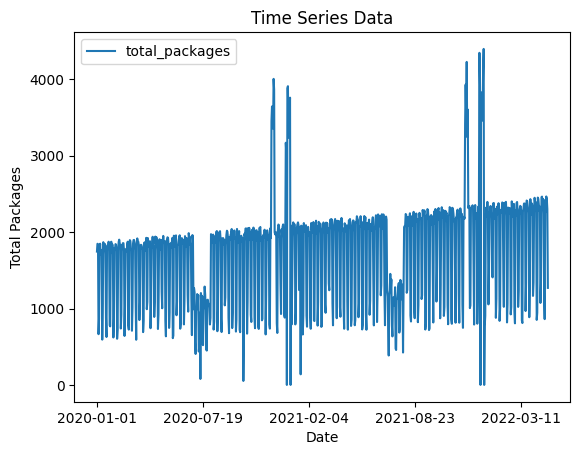

In [44]:
df.plot(x='date', y='total_packages')
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Total Packages')
plt.show()

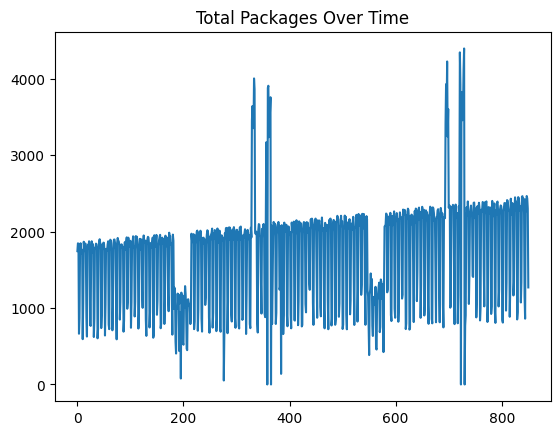

In [5]:
df['total_packages'].plot()
plt.title('Total Packages Over Time')
plt.show()

# Det finns spikar i november och december, vad kan det bero på?

Jul är en återkommande högtid med högre antal paket skickade än det normala som borde påverka antal paket skickade i november och december.

In [6]:
df['date'] = pd.to_datetime(df['date'])

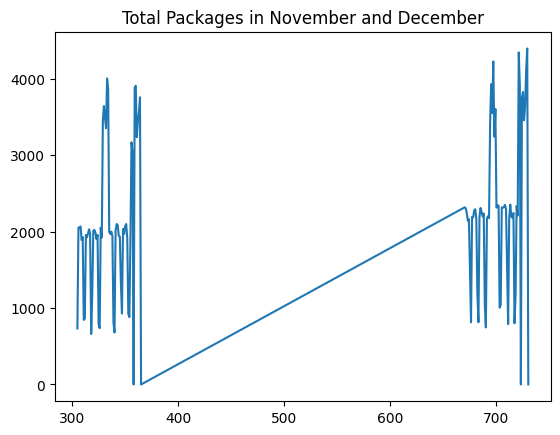

In [7]:
nov_dec = df[(df['date'].dt.month == 11) | (df['date'].dt.month == 12)]
nov_dec['total_packages'].plot()
plt.title('Total Packages in November and December')
plt.show()

# Finns det någon trend?

Runt juli 2020 verkar det finnas en övergripande nedåtgående trend som verkar återkomma, då det ser lika ut i juli 2021. Sedan är det en stark uppåtgående trend kring november december 2020 och 2021.

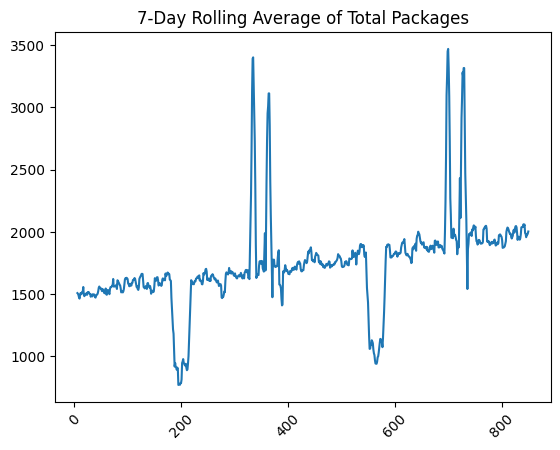

In [8]:
df['date'] = df['date'].dt.strftime('%Y-%m-%d')
rolling_mean = df['total_packages'].rolling(window=7).mean()
rolling_mean.plot()
plt.xticks(rotation=45)
plt.title('7-Day Rolling Average of Total Packages')
plt.show()


# Finns det några dagar med extrema värden?

Ja det finns dagar med extrema värden/högre än det normala, inför julen sent i november och julveckan i december.

In [9]:
from scipy.stats import zscore

df['z_score'] = zscore(df['total_packages'])
outliers = df[(df['z_score'] > 3) | (df['z_score'] < -3)]
print(outliers)

           date  total_packages  cooled_packages  fire_packages   
333  2020-11-29            4005              715            917  \
334  2020-11-30            3865              826           1044   
359  2020-12-25            3881              730           1088   
360  2020-12-26            3909              740            768   
695  2021-11-26            3930              728            851   
697  2021-11-28            4227              885           1179   
721  2021-12-22            4346             1027           1077   
722  2021-12-23            3924              970            983   
725  2021-12-26            3828              536            789   
728  2021-12-29            4122              893            920   
729  2021-12-30            4397              933           1246   

     normal_packages   z_score  
333             2373  3.323928  
334             1995  3.118534  
359             2063  3.142007  
360             2401  3.183086  
695             2351  3.213895

# Träna en facebook prophet modell

# Träna modellen på all data före 2022-04-01

In [182]:
df = df.rename(columns={'date': 'ds', 'total_packages': 'y'})
train_df = df[df['ds'] < '2022-04-01']

model = Prophet()
model.fit(train_df)

23:15:28 - cmdstanpy - INFO - Chain [1] start processing
23:15:28 - cmdstanpy - INFO - Chain [1] done processing


# Testa modellen på all data från 2022-04-01 och framåt

In [183]:
test_df = df[df['ds'] >= '2022-04-01']
future = model.make_future_dataframe(periods=len(test_df), freq='D')
future_forecast = model.predict(future)

# Hur har modellen prognostiserat träningsdatan

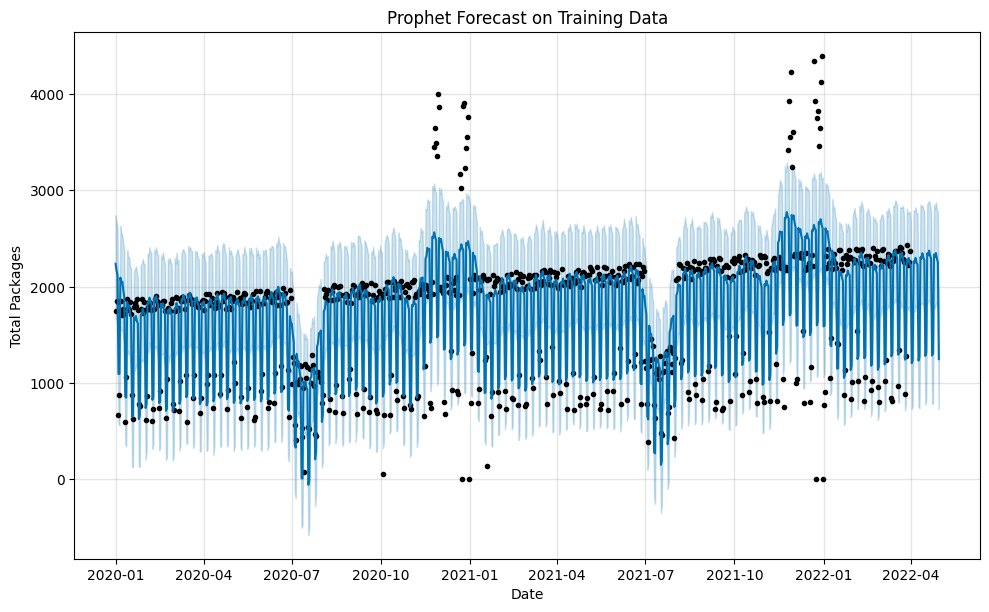

In [184]:
fig = model.plot(future_forecast, xlabel='Date', ylabel='Total Packages')
plt.title('Prophet Forecast on Training Data')
plt.show()

# Rita ut modellens komponenter (trend och säsongsvariation)

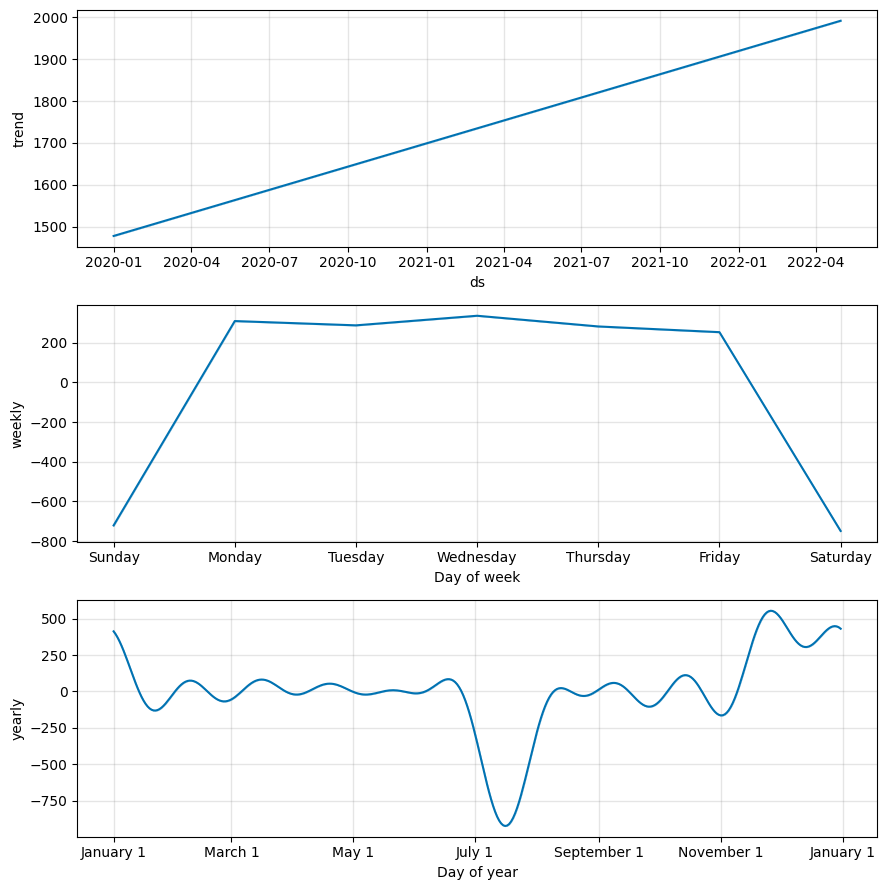

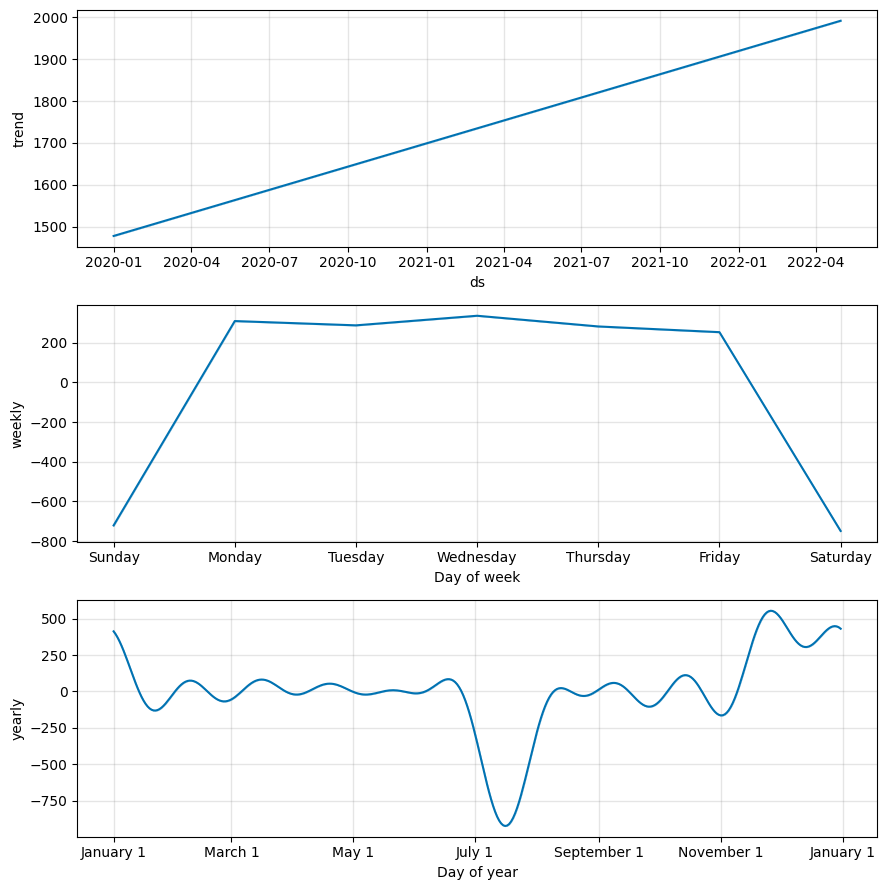

In [33]:
model.plot_components(future_forecast)

# Kör modellen mot testdatan och se om den presterar bättre än planeringen på 2000 paket om dagen

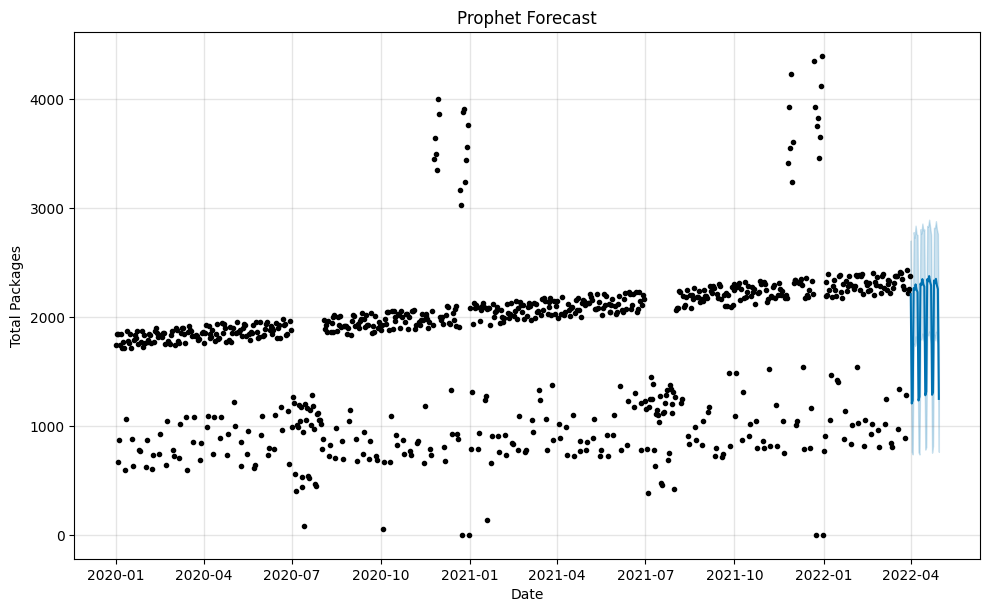

In [176]:
test_forecast = model.predict(test_df)
fig = model.plot(test_forecast, xlabel='Date', ylabel='Total Packages')
plt.title('Prophet Forecast')
plt.show()

# För att jämföra modellen med ursprungliga planeringen ska AME (absolute mean error) användas

In [178]:
from sklearn.metrics import mean_absolute_error

mae_forecast = mean_absolute_error(test_df['y'], test_forecast['yhat'])
plan = [2000] * len(test_df)
mae_plan = mean_absolute_error(test_df['y'], plan)
print("Forecast",mae_forecast)
print("Plan",mae_plan)
if mae_forecast < mae_plan:
    print("The model performs better than the plan of 2000 packages per day.")
else:
    print("The plan of 2000 packages per day performs better than the model.")

Forecast 117.51677761411868
Plan 524.9666666666667
The model performs better than the plan of 2000 packages per day.


# Gör en prognostisering för Juni 2022 och rita ut.

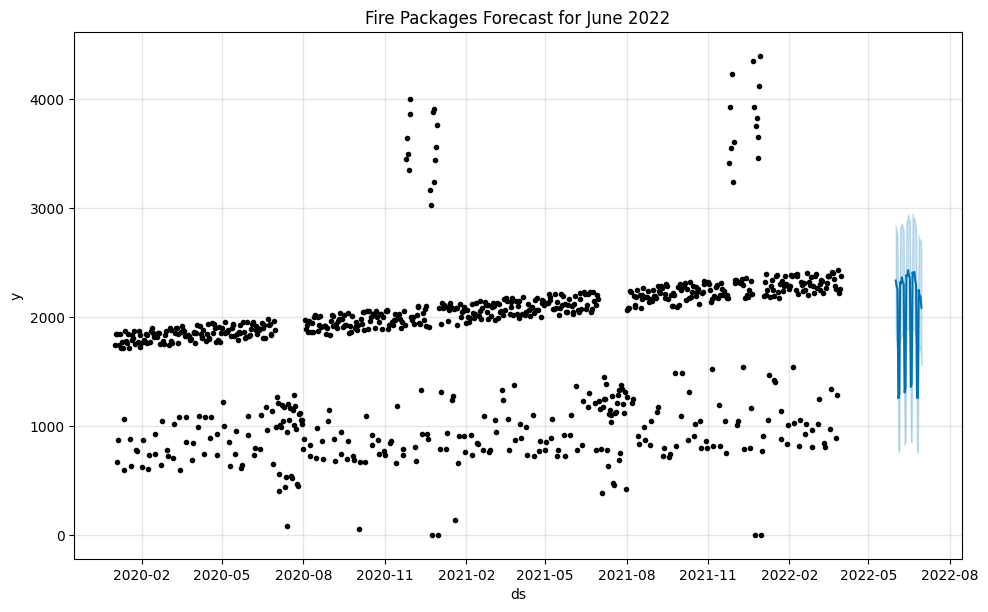

In [175]:
total_june = pd.DataFrame({'ds': pd.date_range(start='2022-06-01', end='2022-06-30', freq='D')})
forecast_june = model.predict(total_june)

fig = model.plot(forecast_june)
plt.title('Fire Packages Forecast for June 2022')
plt.show()

# VG

# Träna ytterligare tre facebook prophet modeller.
# Prognostiseringen för totala antalet paket ska användas som input för varje modell.

# ○ En för normala paket.

In [170]:
df_normal = pd.read_csv('incoming_packages.csv')
df_normal = df_normal.rename(columns= {'date': 'ds', 'normal_packages': 'y'})
df_normal['ds'] = pd.to_datetime(df_normal['ds'])
test_forecast['ds'] = pd.to_datetime(future_forecast['ds'])

df_normal = df_normal.merge(future_forecast[['ds', 'yhat']], on='ds', how='left')
df_normal = df_normal.rename(columns={'yhat': 'total_forecast'})

train_normal = df_normal[df_normal['ds'] < '2022-04-01']
test_normal = df_normal[df_normal['ds'] >= '2022-04-01']

model_normal = Prophet()
model_normal.add_regressor('total_forecast')
model_normal.fit(train_normal)
forecast_normal = model_normal.predict(test_normal)

22:56:13 - cmdstanpy - INFO - Chain [1] start processing
22:56:13 - cmdstanpy - INFO - Chain [1] done processing


# Räkna ut medelvärdet av fel för varje dag i testdatan

In [172]:
errors = forecast_normal['yhat'] - test_normal['y']
mean_error_per_day = errors.groupby(test_normal['ds'].dt.date).mean().reset_index()
mean_error_per_day = mean_error_per_day.rename(columns={0: 'mean_error', 'ds':'date'})
print(mean_error_per_day)

          date  mean_error
0   2022-04-01 -227.647119
1   2022-04-02   11.614433
2   2022-04-03  -55.449993
3   2022-04-04  -99.901408
4   2022-04-05 -292.883966
5   2022-04-06  -61.137870
6   2022-04-07  -12.975324
7   2022-04-08    4.080577
8   2022-04-09  277.775670
9   2022-04-10  235.650521
10  2022-04-11  -42.494324
11  2022-04-12 -269.918767
12  2022-04-13  -40.452904
13  2022-04-14 -156.470682
14  2022-04-15  -25.527440
15  2022-04-16  203.120289
16  2022-04-17 -101.960001
17  2022-04-18 -207.913062
18  2022-04-19 -180.918699
19  2022-04-20  195.295318
20  2022-04-21   35.475782
21  2022-04-22   70.202145
22  2022-04-23  160.361996
23  2022-04-24  210.671329
24  2022-04-25  -93.866725
25  2022-04-26   40.710410
26  2022-04-27  -22.192763
27  2022-04-28   -3.711472
28  2022-04-29  -55.166203
29  2022-04-30   34.409827


# Rita ut modellens komponenter (trend och säsongsvariation)

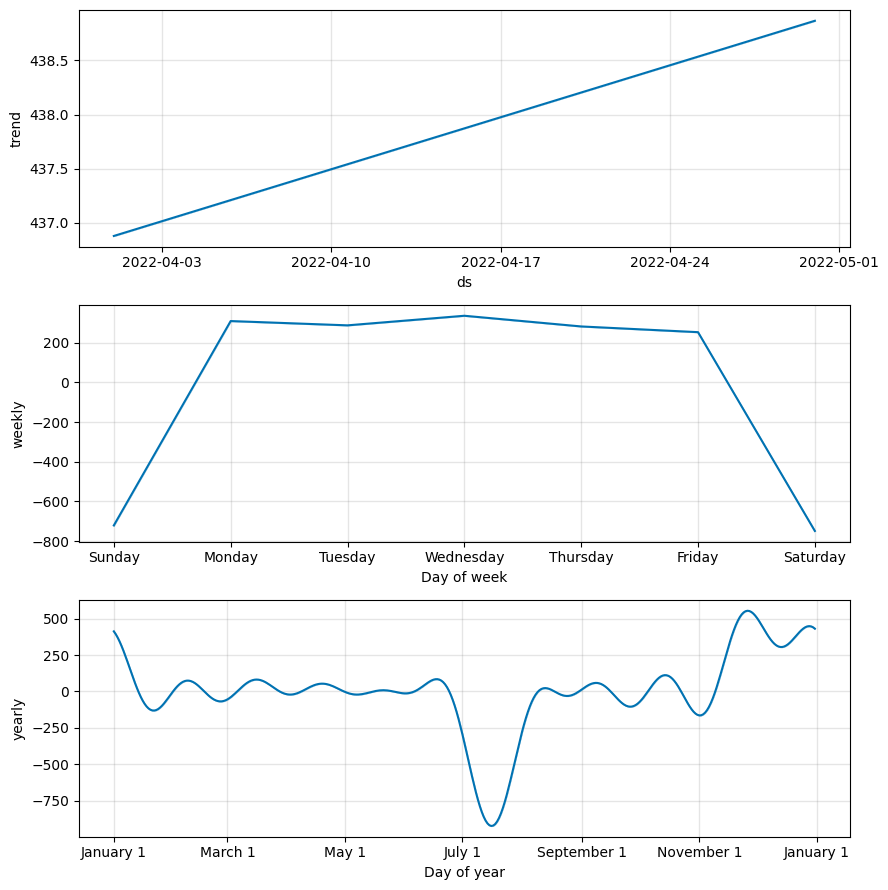

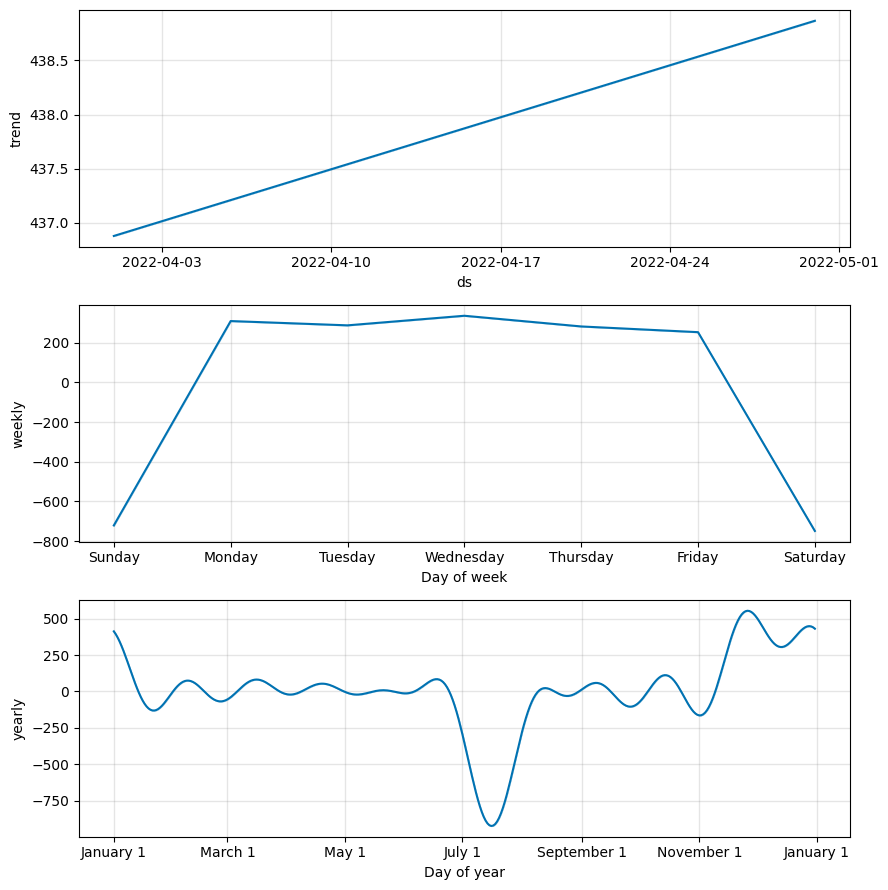

In [65]:
model.plot_components(forecast_normal)

# Gör en prognostisering för Juni 2022 och rita ut.

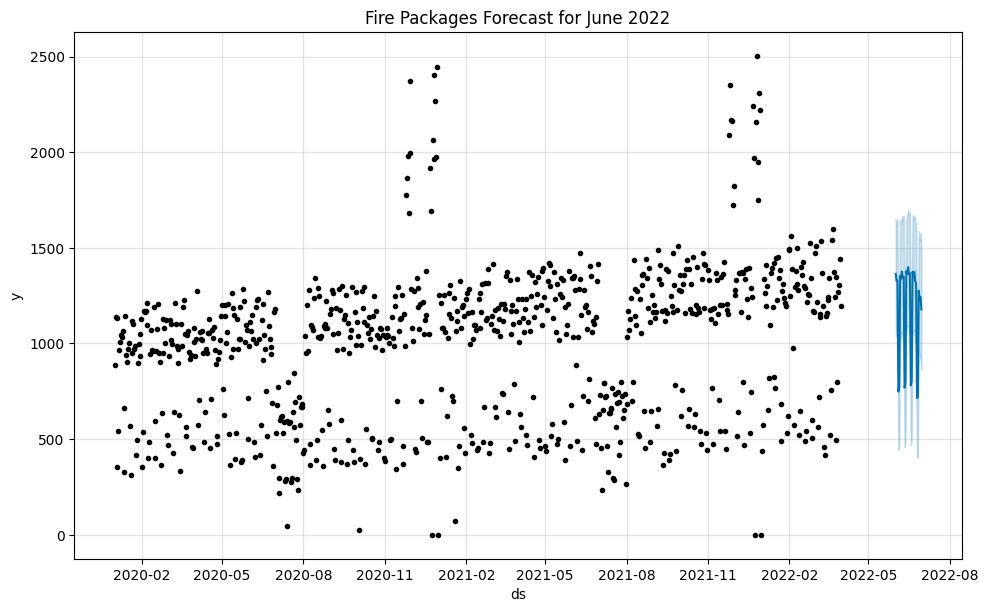

In [174]:
future_normal = pd.DataFrame({'ds': pd.date_range(start='2022-06-01', end='2022-06-30')})
future_normal = future_normal.merge(forecast_june[['ds', 'yhat']], on='ds', how='left')
future_normal = future_normal.rename(columns={'yhat': 'total_forecast'})

forecast_fire = model_normal.predict(future_normal)
fig = model_normal.plot(forecast_fire)
plt.title('Fire Packages Forecast for June 2022')
plt.show()

# ○ En för kylda paket.

In [146]:
df_chilled = pd.read_csv('incoming_packages.csv')
df_chilled = df_chilled.rename(columns= {'date': 'ds', 'cooled_packages': 'y'})
df_chilled['ds'] = pd.to_datetime(df_chilled['ds'])
test_forecast['ds'] = pd.to_datetime(future_forecast['ds'])

df_chilled = df_chilled.merge(future_forecast[['ds', 'yhat']], on='ds', how='left')
df_chilled = df_chilled.rename(columns={'yhat': 'total_forecast'})

train_chilled = df_chilled[df_chilled['ds'] < '2022-04-01']
test_chilled = df_chilled[df_normal['ds'] >= '2022-04-01']

model_chilled = Prophet()
model_chilled.add_regressor('total_forecast')
model_chilled.fit(train_chilled)
forecast_chilled = model_normal.predict(test_chilled)

22:43:55 - cmdstanpy - INFO - Chain [1] start processing
22:43:55 - cmdstanpy - INFO - Chain [1] done processing


Index(['ds', 'total_packages', 'y', 'fire_packages', 'normal_packages',
       'total_forecast'],
      dtype='object')


# Räkna ut medelvärdet av fel för varje dag i testdatan

In [150]:
errors = forecast_chilled['yhat'] - test_chilled['y']
mean_error_per_day = errors.groupby(test_chilled['ds'].dt.date).mean().reset_index()
mean_error_per_day = mean_error_per_day.rename(columns={0: 'mean_error', 'ds':'date'})
print(mean_error_per_day)

          date  mean_error
0   2022-04-01  178.090183
1   2022-04-02   48.507849
2   2022-04-03   29.061172
3   2022-04-04  122.337563
4   2022-04-05  125.438707
5   2022-04-06  103.506113
6   2022-04-07   17.041577
7   2022-04-08   98.889274
8   2022-04-09   82.023117
9   2022-04-10   91.954555
10  2022-04-11   94.221867
11  2022-04-12  161.890863
12  2022-04-13  126.081547
13  2022-04-14  205.289225
14  2022-04-15  108.366735
15  2022-04-16   76.311472
16  2022-04-17   91.672344
17  2022-04-18  168.037785
18  2022-04-19   94.534767
19  2022-04-20    2.353405
20  2022-04-21   -2.934264
21  2022-04-22   53.605402
22  2022-04-23   71.052001
23  2022-04-24  156.035337
24  2022-04-25  114.220769
25  2022-04-26   76.805700
26  2022-04-27  116.041882
27  2022-04-28   -9.447822
28  2022-04-29  150.308602
29  2022-04-30   51.415435


# Rita ut modellens komponenter (trend och säsongsvariation)

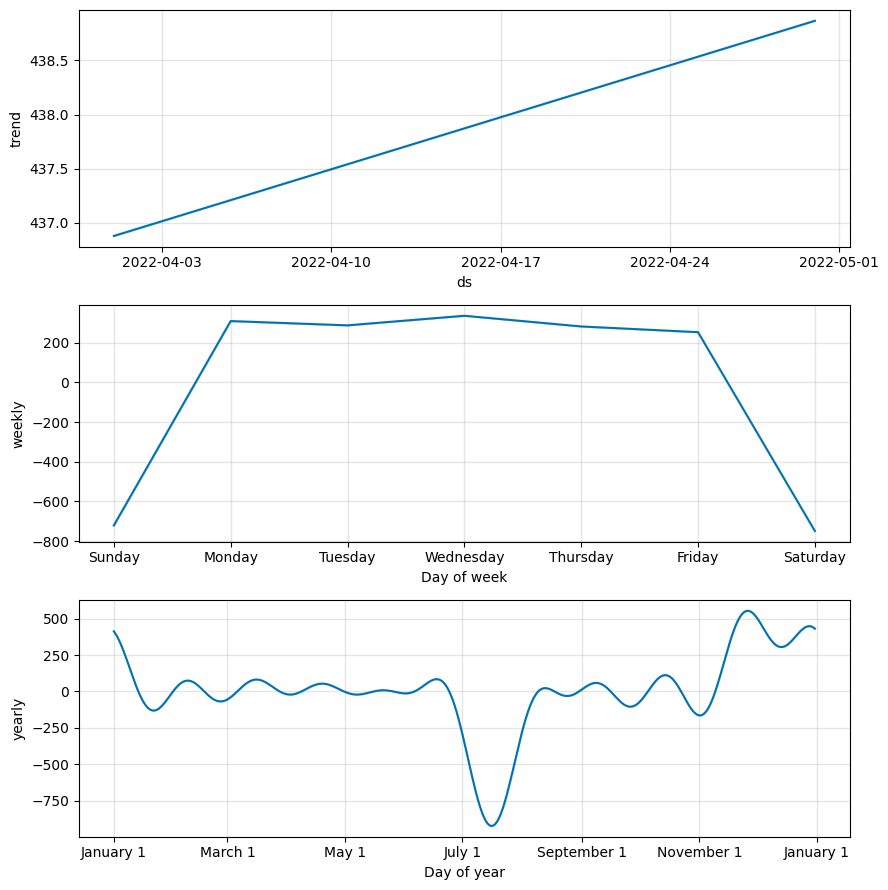

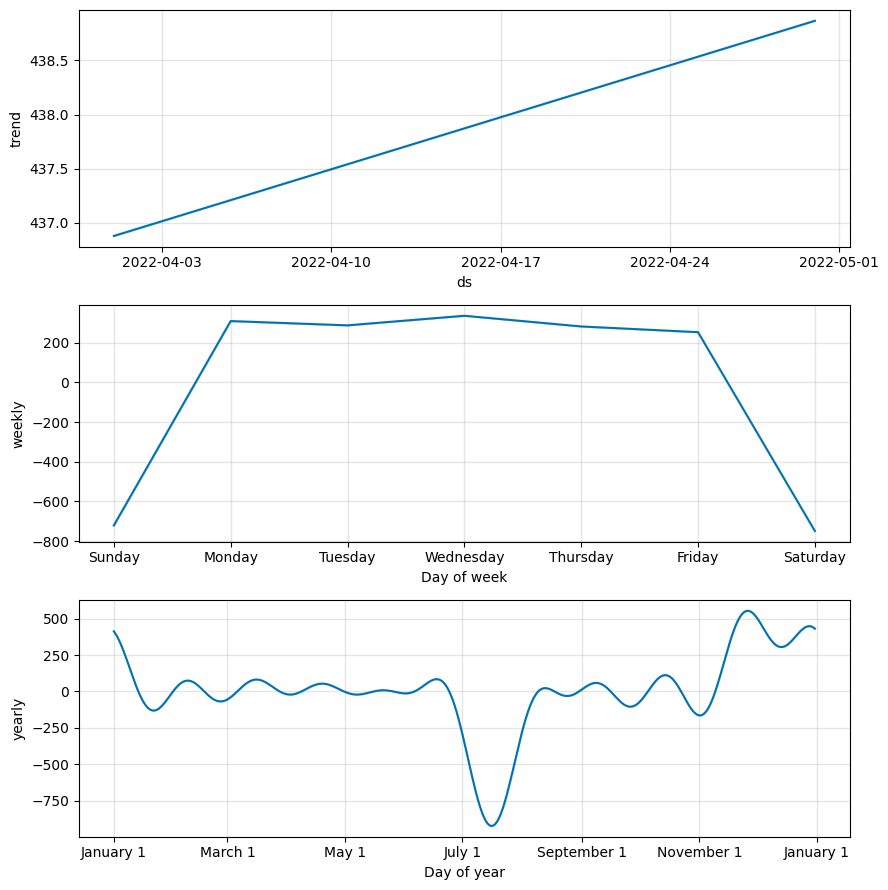

In [61]:
model.plot_components(forecast_chilled)

# Gör en prognostisering för Juni 2022 och rita ut.

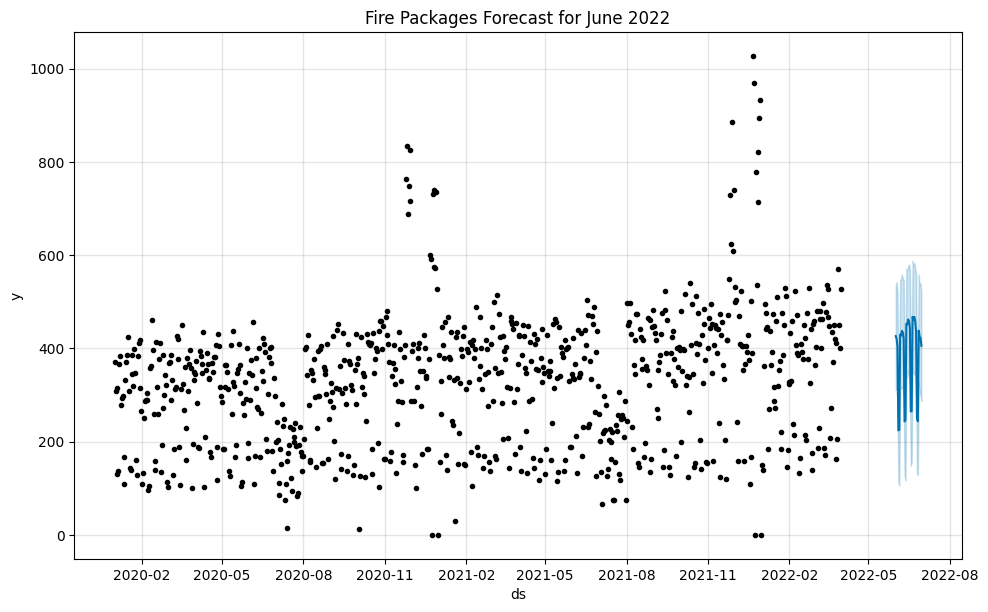

In [173]:
future_chilled = pd.DataFrame({'ds': pd.date_range(start='2022-06-01', end='2022-06-30')})
future_chilled = future_chilled.merge(forecast_june[['ds', 'yhat']], on='ds', how='left')
future_chilled = future_chilled.rename(columns={'yhat': 'total_forecast'})

forecast_chilled = model_chilled.predict(future_chilled)
fig = model_chilled.plot(forecast_chilled)
plt.title('Fire Packages Forecast for June 2022')
plt.show()

# ○ En för brandfarliga paket.

In [157]:
df_fire = pd.read_csv('incoming_packages.csv')
df_fire = df_fire.rename(columns= {'date': 'ds', 'fire_packages': 'y'})
df_fire['ds'] = pd.to_datetime(df_fire['ds'])
test_forecast['ds'] = pd.to_datetime(future_forecast['ds'])

df_fire = df_fire.merge(future_forecast[['ds', 'yhat']], on='ds', how='left')
df_fire = df_fire.rename(columns={'yhat': 'total_forecast'})

train_fire = df_fire[df_fire['ds'] < '2022-04-01']
test_fire = df_fire[df_fire['ds'] >= '2022-04-01']

print(df_fire.columns)

model_fire = Prophet()
model_fire.add_regressor('total_forecast')
model_fire.fit(train_fire)
forecast_fire = model_fire.predict(test_fire)

22:49:45 - cmdstanpy - INFO - Chain [1] start processing
22:49:45 - cmdstanpy - INFO - Chain [1] done processing


Index(['ds', 'total_packages', 'cooled_packages', 'y', 'normal_packages',
       'total_forecast'],
      dtype='object')


# Räkna ut medelvärdet av fel för varje dag i testdatan

In [164]:
errors = forecast_fire['yhat'] - test_fire['y']
mean_error_per_day = errors.groupby(test_fire['ds'].dt.date).mean().reset_index()
mean_error_per_day = mean_error_per_day.rename(columns={0: 'mean_error', 'ds':'date'})
print(mean_error_per_day)


          date  mean_error
0   2022-04-01   35.090183
1   2022-04-02   30.507849
2   2022-04-03  -20.938828
3   2022-04-04   75.337563
4   2022-04-05   76.438707
5   2022-04-06  -15.493887
6   2022-04-07  -37.958423
7   2022-04-08  -17.110726
8   2022-04-09   80.023117
9   2022-04-10   58.954555
10  2022-04-11  -84.778133
11  2022-04-12   85.890863
12  2022-04-13   34.081547
13  2022-04-14   92.289225
14  2022-04-15  -17.633265
15  2022-04-16   -6.688528
16  2022-04-17   54.672344
17  2022-04-18   46.037785
18  2022-04-19   72.534767
19  2022-04-20  -28.646595
20  2022-04-21  -25.934264
21  2022-04-22   47.605402
22  2022-04-23  -33.947999
23  2022-04-24  149.035337
24  2022-04-25    8.220769
25  2022-04-26   40.805700
26  2022-04-27  -92.958118
27  2022-04-28  -20.447822
28  2022-04-29  -28.691398
29  2022-04-30  -52.584565


# Rita ut modellens komponenter (trend och säsongsvariation)

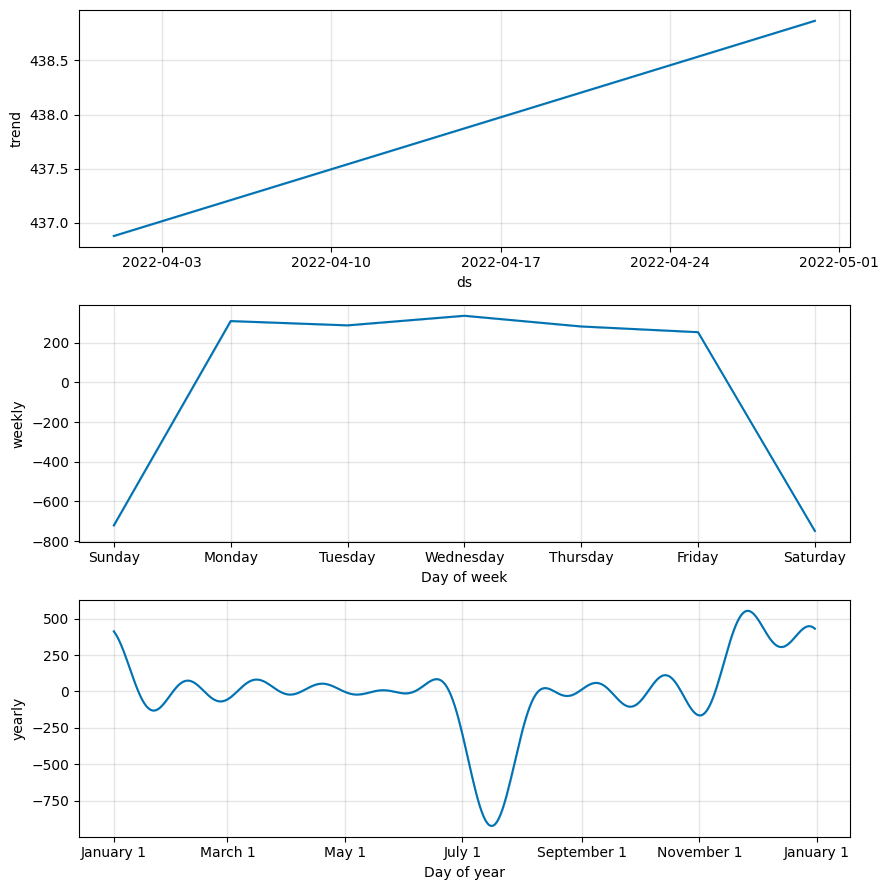

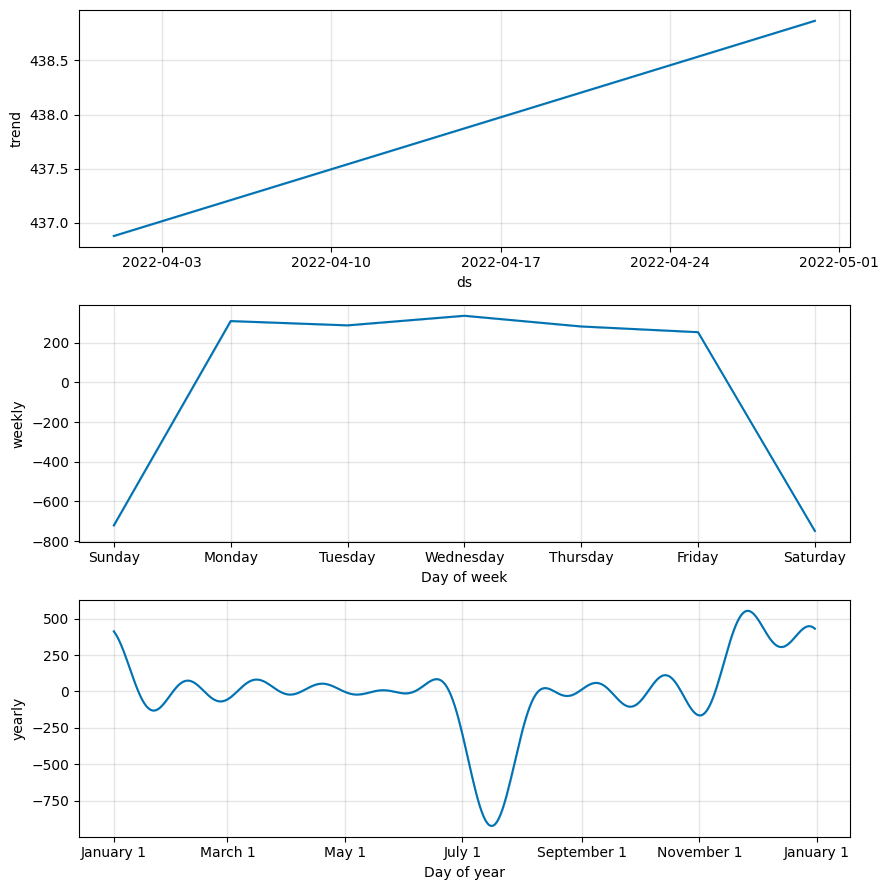

In [67]:
model.plot_components(forecast_fire)

# Gör en prognostisering för Juni 2022 och rita ut.

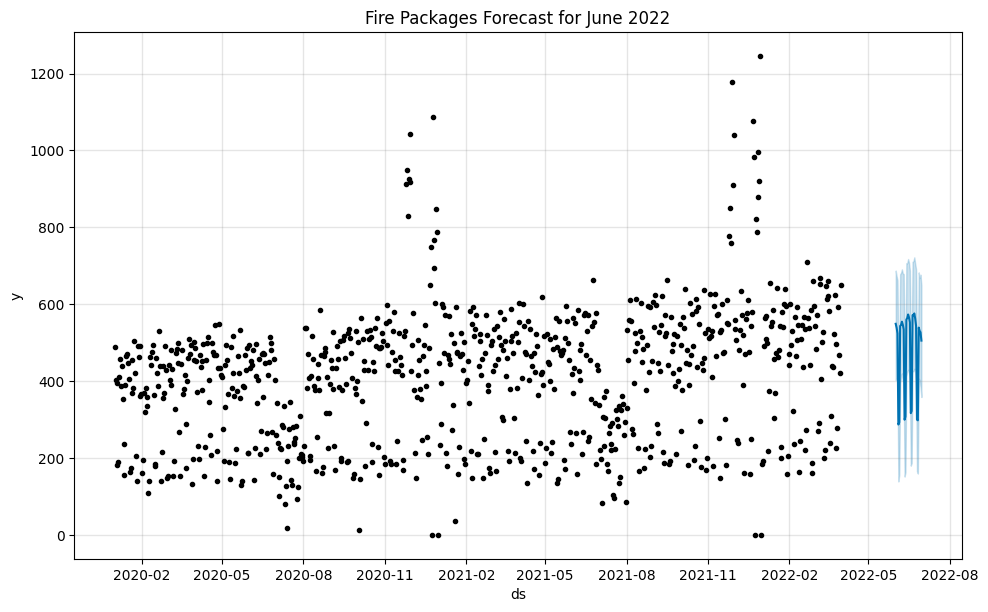

In [82]:
future_fire = pd.DataFrame({'ds': pd.date_range(start='2022-06-01', end='2022-06-30')})
future_fire = future_fire.merge(forecast_june[['ds', 'yhat']], on='ds', how='left')
future_fire = future_fire.rename(columns={'yhat': 'total_forecast'})

forecast_fire = model_fire.predict(future_fire)
fig = model_fire.plot(forecast_fire)
plt.title('Fire Packages Forecast for June 2022')
plt.show()